In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [148]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot

In [137]:
def convertStreak(streak):
    # N is post season?
    if streak == "N":
        return float('Nan')
    sign = -1 if streak[0] == "-" else 1
    return len(streak) * sign

def getDateConverter(year):
    def convertDate(date):
        # Handle duplicate headers
        if date == 'Date':
            return None
        
        # Remove double-header indication (1), (2) and convert to date
        d = datetime.datetime.strptime(re.sub(r'\s\(.*\)', '', date) + ' ' + str(year), '%A %b %d %Y')
        #d.year = year
        return d
    
    return convertDate

def convertWL(wl):
    # Covert the W/L column to numeric
    if wl and wl[0] == 'W':
        return 1
    return 0

def readGameLog(csv, convertDate):
    df = pd.read_csv(csv, skip_blank_lines=True, converters={'Streak': convertStreak, 'Date': convertDate, 'W/L': convertWL})
    
    # Remove the headers in the middle of the file and postseason
    df = df.drop(df.index[
        (df.Rk == "Rk") | # Drop header rows
        np.isnan(df.Streak) # Post Season
    ])
    
    # First game in double headers
    df = df.drop(df.index[(np.append(np.diff(df.Date).astype(int), [1]) == 0)])
    
    return df

In [138]:
df = readGameLog("teams_NYM_2015-schedule-scores_team_schedule.csv", getDateConverter(2015))

In [133]:
df.columns

Index([u'Rk', u'Gm#', u'Date', u'Unnamed: 3', u'Tm', u'Unnamed: 5', u'Opp',
       u'W/L', u'R', u'RA', u'Inn', u'W-L', u'Rank', u'GB', u'Win', u'Loss',
       u'Save', u'Time', u'D/N', u'Attendance', u'Streak'],
      dtype='object')

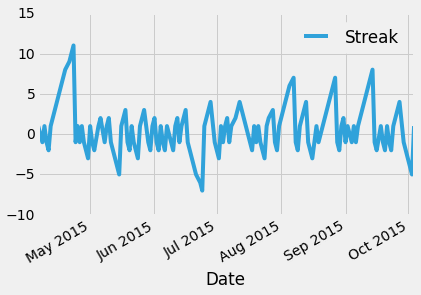

In [134]:
df.plot('Date', 'Streak')

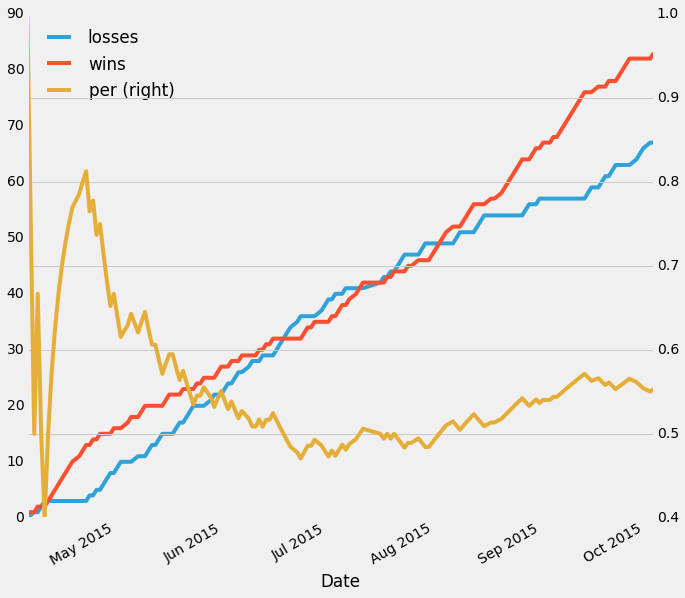

In [129]:
df['wins'] = np.cumsum(df['W/L'] == 'W')
df['losses'] = np.cumsum(df['W/L'] == 'L')
df['per'] = df['wins'] / (df['wins'] + df['losses'])
figure, ax = pl.subplots(figsize=(10,10))
df.plot('Date', 'losses', ax=ax)
df.plot('Date', 'wins', ax=ax)
df.plot('Date', 'per', ax=ax, secondary_y=True)

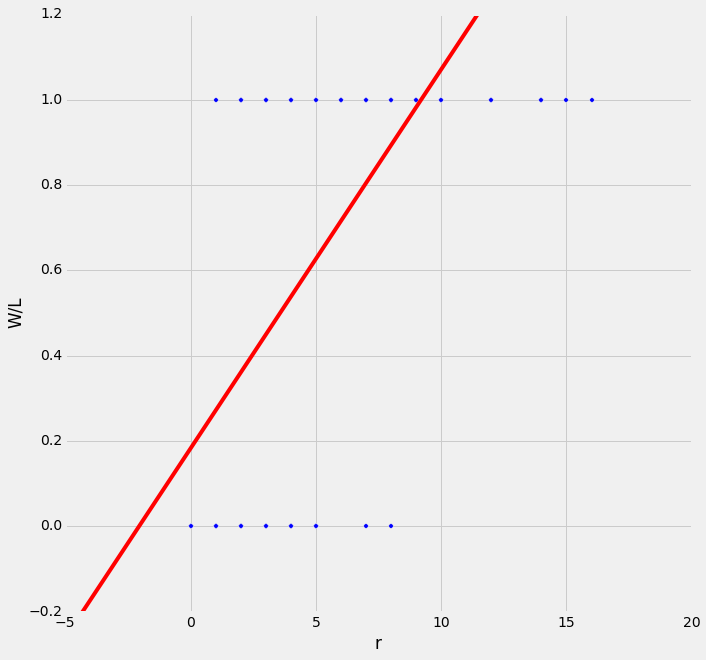

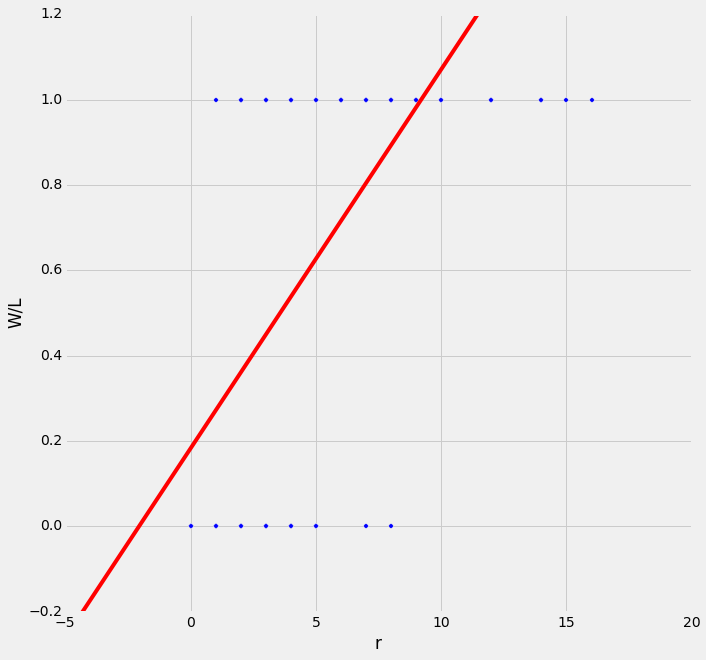

In [155]:
df['r'] = df.R.astype(int)
figure, ax = pl.subplots(figsize=(10,10))
df.plot('r', 'W/L', kind='scatter', ax=ax)
df['wl'] = df['W/L']
mod = smf.ols(formula='wl ~ r', data = df).fit()
abline_plot(model_results=mod, ax=ax, color='red')